In [1]:
import ee
ee.Initialize();
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import time

In [10]:
"""Composite an image collection and clip it to a boundary from a fusion table.
See also: Filtered Seasonal Composite, which filters the
collection by bounds instead.
"""

# Clip to the output image to the California state boundary.
area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8')
      .filter(ee.Filter().eq('Name', 'California')))

area = (ee.FeatureCollection('ft:1QPasan0i6O9uUlcYkjqj91D7mbnhTZCmzS4t7t_g').filter(ee.Filter().eq('id', '107')))

# import the RS products

modis = ee.ImageCollection('MCD43A4_NDVI') #

years = [x for x in range(2000, 2016)]

In [11]:
# Functions

def filter_date_modis(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select("NDVI")
    return prod

def aggregate(product,year):

    # Filter
    filtered = filter_date_modis(product, year)
    
    # bbox 
    bounds = area.geometry().bounds()

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(2,9)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).mean();
                clipped = w.clip(area)
                mask = clipped.mask()
                masked = ee.Image(0).where(mask, clipped)
                fin = masked.clip(bounds)
                mylist = mylist.add(fin.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    seasonal = ee.ImageCollection(calcMean(filtered, year))
    
    # select the region of interest, 500 is the cellsize in meters
    seasonal = seasonal.getRegion(bounds,500,"epsg:4326").getInfo()

    return seasonal 

def make_df_from_imcol(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df.constant)
    
    return lons, lats, data

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable):
    df = df[df.id == "6"] # TODO : average on 0-6
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
    
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

In [12]:
finals_modis = []
for year in years:
    finals_modis.append(aggregate(modis,year))

In [13]:
fin_modis_dfs = []
for i in finals_modis:
    fin_modis_dfs.append(df_from_ee_object(i))

In [14]:
arrs = []
for i in fin_modis_dfs:
    arrs.append(array_from_df(i,"constant"))

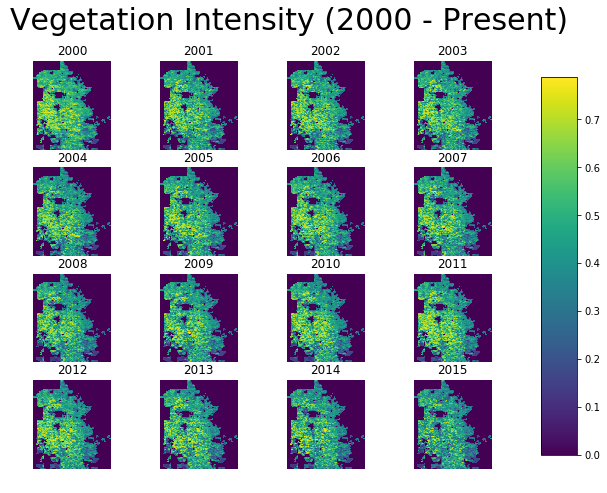

In [15]:
#del(fig,axs)

fig, axs = plt.subplots(4,4, figsize=(10,7.5))
axs = axs.ravel()

plt.suptitle('Vegetation Intensity (2000 - Present)', size = 30)

for i in range(len(arrs)):
    
    a = axs[i].imshow(arrs[i])#(fin_modis_dfs[i]['longitude'],fin_modis_dfs[i]['latitude'],marker = "s",c = fin_modis_dfs[i]['constant'],s= 20, lw = 0)
    axs[i].set_title(2000+i)
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(a, cax=cbar_ax)
plt.show()

In [16]:
# Grab the training data 
cwd = os.getcwd()
y_dir = [os.path.join(cwd,x) for x in os.listdir(os.getcwd()) if "yields" in x][2]
fn = [os.path.join(y_dir,x) for x in os.listdir(y_dir) if "107" in x][0]

d = json.load(open(fn))
yrs = [str(x) for x in years]
d_2 = { year: d[year] for year in yrs }
training = d_2.values()

In [43]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

num_cores = 4
GPU=1
CPU=0

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
                       log_device_placement=True)
session = tf.Session(config=config)
K.set_session(session)

K.set_image_dim_ordering('th')

In [44]:
X_train = np.stack(arrs[:-2])
y_train = np.stack(training[:-2])
X_test = np.stack(arrs[-2:])
y_test = np.stack(training[-2:])
X_train = np.tile(X_train,(10,1,1))
y_train = np.tile(y_train,(10))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140, 195, 170), (2, 195, 170), (140,), (2,))

In [45]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]).astype('float32')
X_train.shape, X_test.shape, y_test.shape, y_train.shape

((140, 1, 195, 170), (2, 1, 195, 170), (2,), (140,))

In [46]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

TypeError: Invalid dimensions for image data

In [47]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 195, 170), activation='relu'))
    model.add(Conv2D(64, (20, 20), input_shape=(1, 195, 170), activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 191, 166)      832       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 172, 147)      819264    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 34, 29)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 34, 29)        0         
_________________________________________________________________
dense_7 (Dense)              (None, 64, 34, 64)        1920      
_________________________________________________________________
flatten_4 (Flatten)          (None, 139264)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 139264)            0         
__________

In [48]:
# build the model
core_time=[0]*8
for x in range(1,9):
    num_cores = x
    print("Running",2,"epochs with",x,"cores")
    config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
        log_device_placement=True)
    session = tf.Session(config=config)
    K.set_session(session)
    K.set_image_dim_ordering('th')
    model = baseline_model()
    t1=time.time()
    model.fit(X_train, y_train, validation_split=0.1, epochs=2, batch_size=20, verbose=2)


    t2=time.time()

    core_time[x-1]=t2-t1
print(core_time)

('Running', 1, 'epochs with', 4, 'cores')
Train on 126 samples, validate on 14 samples
Epoch 1/1
 - 294s - loss: 15573429148005.5879 - acc: 0.0000e+00 - val_loss: 15569258545152.0000 - val_acc: 0.0000e+00
[0, 0, 0, 294.13974595069885, 0, 0, 0, 0]


In [55]:
error=100*np.abs((model.predict(X_test)-y_test)/y_test)
print(error)
#print("CNN Error: %.2f%%" % error[0])

[[ 96.75225196  96.55194356]
 [ 96.88884431  96.69696039]]


In [109]:
output=np.squeeze(model.predict(X_test))
output=abs(output-y_test)
100-100*(output/y_test)


array([ 81.88013318,  83.22301392])